In [ ]:
# =============================================================================
# 1. Importing Packages
# =============================================================================
import pandas as pd
import torch
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    pipeline,
    AutoTokenizer,
    AutoModel,
    utils,
)
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import warnings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import shap
import scipy as sp
import torch.nn as nn
from captum.attr import LayerIntegratedGradients

warnings.filterwarnings("ignore")

In [4]:
# =============================================================================
# 2. Loading and Exploring the Dataset
# =============================================================================
df = pd.read_csv("1900rows_data.csv")
df = df[["text", "og_label", "LABEL"]]
df = df.rename(columns={"text": "phrase", "LABEL": "label"})
print("Data head:\n", df.head())
print("Data shape:", df.shape)
print("Label counts:\n", df["label"].value_counts())
print("Random sample:\n", df.sample(5))
df = df.drop("og_label", axis=1)
print("Data after dropping 'og_label':\n", df.head())

Data head:
                                               phrase          og_label  \
0                    When I remember her I feel down    Emotional pain   
1  When I carry heavy things I feel like breaking...  Hair falling out   
2          there is too much pain when i move my arm       Heart hurts   
3  My son had his lip pierced and it is swollen a...    Infected wound   
4             My muscles in my lower back are aching    Infected wound   

                              label  
0   Neurological & General Symptoms  
1  Dermatological & Skin Conditions  
2                Chronic Conditions  
3                        Infections  
4                        Infections  
Data shape: (1906, 3)
Label counts:
 label
Infections                          356
Dermatological & Skin Conditions    340
Chronic Conditions                  281
Pain-related Conditions             262
Respiratory & Sensory Issues        237
Gastrointestinal Conditions         127
Neurological & General Symptoms 

In [ ]:
# =============================================================================
# 3. Preprocessing the Dataset
# =============================================================================
unique_labels = df["label"].unique().tolist()
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}
df["label_id"] = df["label"].map(label2id)
print("Data with label IDs:\n", df.head())

train_df_og, test_df = train_test_split(df, test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df_og, test_size=0.20, random_state=42)

train_dataset = Dataset.from_pandas(train_df[["phrase", "label_id"]])
val_dataset = Dataset.from_pandas(val_df[["phrase", "label_id"]])
test_dataset = Dataset.from_pandas(test_df[["phrase", "label_id"]])

Data with label IDs:
                                               phrase  \
0                    When I remember her I feel down   
1  When I carry heavy things I feel like breaking...   
2          there is too much pain when i move my arm   
3  My son had his lip pierced and it is swollen a...   
4             My muscles in my lower back are aching   

                              label  label_id  
0   Neurological & General Symptoms         0  
1  Dermatological & Skin Conditions         1  
2                Chronic Conditions         2  
3                        Infections         3  
4                        Infections         3  


In [ ]:
# =============================================================================
# 4. Tokenizing the Text Data for BERT-base
# =============================================================================
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


def tokenize_function(example):
    return tokenizer(
        example["phrase"], padding="max_length", truncation=True, max_length=128
    )


train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("label_id", "labels")
val_dataset = val_dataset.rename_column("label_id", "labels")
test_dataset = test_dataset.rename_column("label_id", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/1219 [00:00<?, ? examples/s]

Map:   0%|          | 0/305 [00:00<?, ? examples/s]

Map:   0%|          | 0/382 [00:00<?, ? examples/s]

In [ ]:
# =============================================================================
# 5. Defining the BERT Model and Training
# =============================================================================
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id,
)

model.config.output_attentions = True

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
)


def compute_metrics(eval_pred):
    outputs, labels = eval_pred
    if isinstance(outputs, (tuple, list)):
        logits = outputs[0] if outputs[0].ndim > 1 else outputs[1]
    else:
        logits = outputs
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

val_metrics = trainer.evaluate(eval_dataset=val_dataset)
print("Validation metrics:", val_metrics)
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print("Test metrics:", test_metrics)

model.save_pretrained("my_model")
tokenizer.save_pretrained("my_model")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.957600,0.683798,0.809836,0.802722
2,0.292400,0.408826,0.885246,0.880873
3,0.143200,0.345237,0.908197,0.908843
4,0.057200,0.326222,0.924590,0.924467
5,0.009900,0.366118,0.921311,0.921120


Validation metrics: {'eval_loss': 0.3661176860332489, 'eval_accuracy': 0.921311475409836, 'eval_f1': 0.9211196426946396, 'eval_runtime': 4.2631, 'eval_samples_per_second': 71.544, 'eval_steps_per_second': 9.148, 'epoch': 5.0}
Test metrics: {'eval_loss': 0.23902946710586548, 'eval_accuracy': 0.9450261780104712, 'eval_f1': 0.9450911092296105, 'eval_runtime': 6.521, 'eval_samples_per_second': 58.58, 'eval_steps_per_second': 7.361, 'epoch': 5.0}


('my_model/tokenizer_config.json',
 'my_model/special_tokens_map.json',
 'my_model/vocab.txt',
 'my_model/added_tokens.json')

In [ ]:
# =============================================================================
# Loading the fine-tuned model and tokenizer for inference
# =============================================================================
model_path = "./my_model"
inference_model = BertForSequenceClassification.from_pretrained(model_path)
inference_tokenizer = BertTokenizer.from_pretrained(model_path)
inference_model.config.output_attentions = True

# =============================================================================
# Creating a text-classification pipeline (real world examples)
# =============================================================================
classifier = pipeline(
    task="text-classification", model=inference_model, tokenizer=inference_tokenizer
)

new_texts = [
    "Sometimes my head hurts me",
    "The weather is dirty, thus, I can't breath propery",
]

predictions = classifier(new_texts)
for text, pred in zip(new_texts, predictions):
    print(f"Text: {text}")
    print(f"Prediction: {pred}\n")

Device set to use mps:0


Text: Sometimes my head hurts me
Prediction: {'label': 'Pain-related Conditions', 'score': 0.9965832829475403}

Text: The weather is dirty, thus, I can't breath propery
Prediction: {'label': 'Respiratory & Sensory Issues', 'score': 0.9964278340339661}



In [ ]:
# =============================================================================
# 5.1 BertViz Visualization of Model Attention using model_view
# =============================================================================
from bertviz import model_view

sample_text = "The weather is dirty, thus, I can't breath propery"
inputs = inference_tokenizer.encode(sample_text, return_tensors="pt").to(
    inference_model.device
)
outputs = inference_model(inputs)
attention = outputs[-1]  
tokens = inference_tokenizer.convert_ids_to_tokens(inputs[0].cpu())
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [ ]:
# =============================================================================
# 6. Embedding Analysis & Interpretation
# =============================================================================
## 6.1. Extracting the [CLS] Embeddings
model.config.output_hidden_states = True


def get_cls_embedding(batch):
    inputs_dict = {
        "input_ids": batch["input_ids"].to(model.device),
        "attention_mask": batch["attention_mask"].to(model.device),
    }
    with torch.no_grad():
        outputs = model(**inputs_dict)
    cls_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
    return cls_embeddings


all_embeddings = []
all_labels = []
batch_size = 8
for i in range(0, len(test_dataset), batch_size):
    batch = test_dataset[i : i + batch_size]
    embeddings = get_cls_embedding(batch)
    all_embeddings.append(embeddings)
    all_labels.extend(batch["labels"].numpy())

all_embeddings = np.vstack(all_embeddings)
print("Extracted embeddings shape:", all_embeddings.shape)

Extracted embeddings shape: (382, 768)


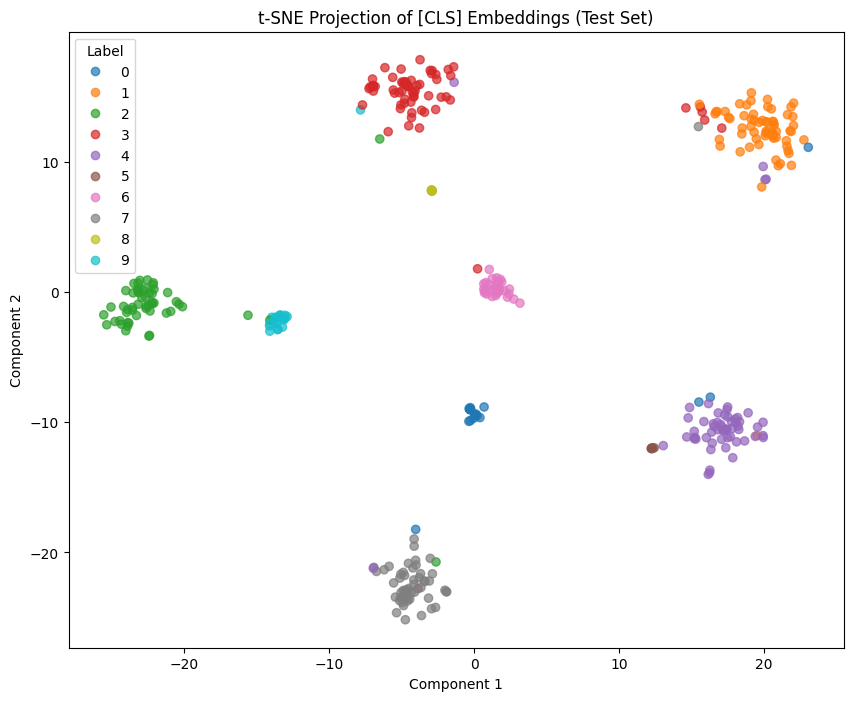

In [11]:
## 6.2. Dimensionality Reduction with t‑SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=np.array(all_labels),
    cmap="tab10",
    alpha=0.7,
)
plt.title("t-SNE Projection of [CLS] Embeddings (Test Set)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(*scatter.legend_elements(), title="Label")
plt.show()

In [ ]:
# =============================================================================
# Additional Analysis: SHAP Explainer for Model Predictions
# =============================================================================
device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)
model.to(device)


def f(texts):
    tokens = [
        tokenizer.encode(t, padding="max_length", max_length=128, truncation=True)
        for t in texts
    ]
    tv = torch.tensor(tokens).to(device)
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    return sp.special.logit(scores[:, 1])


explainer = shap.Explainer(f, tokenizer)
sample_texts = df["phrase"].sample(10).values.tolist()
shap_values = explainer(sample_texts, fixed_context=0)

Text - I feel a strange and powerful pain inside my rib cage


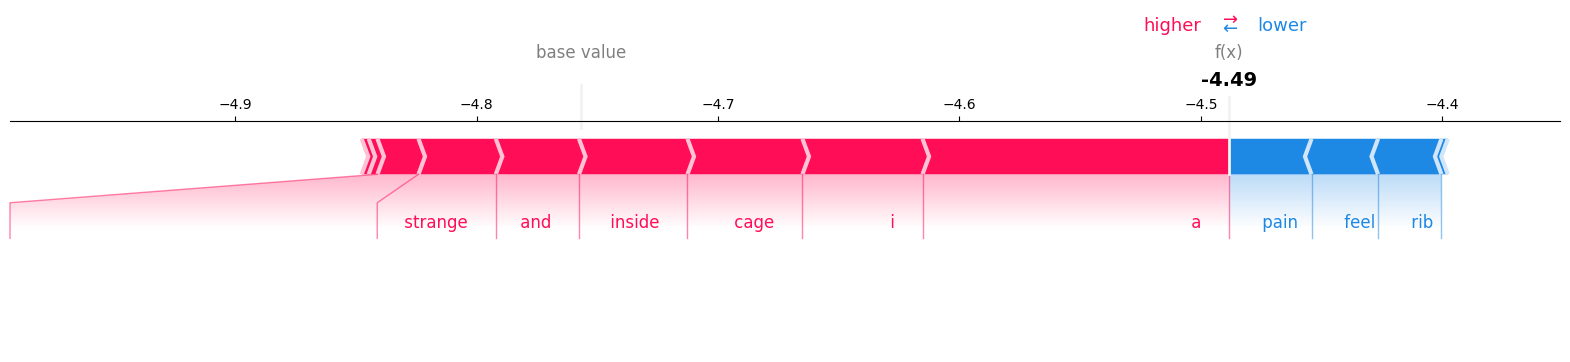

In [24]:
num = 6
shap_values_second = shap_values[num]
print(f"Text - {sample_texts[num]}")
shap.force_plot(
    shap_values_second.base_values,
    shap_values_second.values,
    shap_values_second.data,
    matplotlib=True,
)

Token Attributions:
[CLS]       : 0.1970
sometimes   : 0.4544
my          : 0.9016
head        : 2.9655
hurts       : 1.6961
me          : 0.0530
[SEP]       : 2.6658


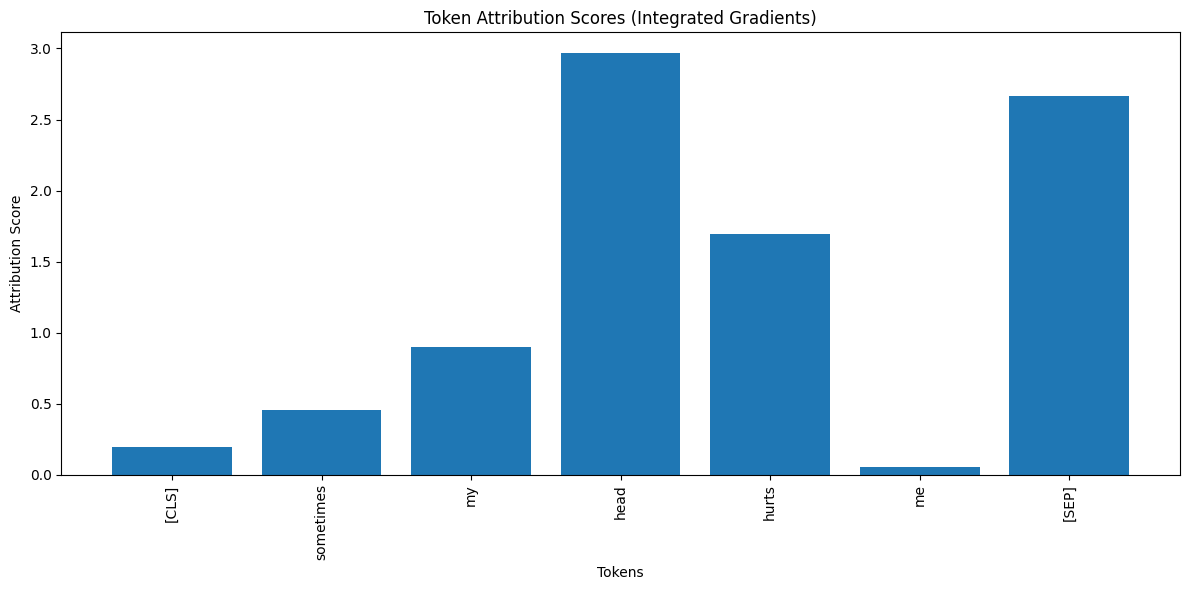

In [ ]:
# =============================================================================
# 7. Captum Visualization for Embedding Analysis with Integrated Gradients
# =============================================================================

captum_text = "Sometimes my head hurts me"
encoded = inference_tokenizer.encode_plus(
    captum_text,
    return_tensors="pt",
    max_length=128,
    truncation=True,
    padding="max_length",
)
input_ids = encoded["input_ids"].to(inference_model.device)
attention_mask = encoded["attention_mask"].to(inference_model.device)

outputs = inference_model(input_ids, attention_mask=attention_mask)
target_class = torch.argmax(outputs.logits, dim=1).item()


def custom_forward(input_ids, attention_mask):
    outputs = inference_model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.logits[:, target_class]

baseline = torch.full_like(input_ids, fill_value=inference_tokenizer.pad_token_id).to(
    inference_model.device
)

lig = LayerIntegratedGradients(custom_forward, inference_model.bert.embeddings)

attributions, delta = lig.attribute(
    inputs=input_ids,
    additional_forward_args=attention_mask,
    baselines=baseline,
    return_convergence_delta=True,
)

attributions_sum = attributions.sum(dim=-1).squeeze(0)

tokens = inference_tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).cpu())

real_length = int(attention_mask.sum().item())
tokens = tokens[:real_length]
attributions_sum = attributions_sum[:real_length]

# --- Fallback Visualization Functions ---


# A. Simple print function for tokens and attributions.
def simple_visualize_text(tokens, attributions):
    print("Token Attributions:")
    for token, attr in zip(tokens, attributions):
        print(f"{token:12s}: {attr:.4f}")


# B. Plot attributions using matplotlib.
def plot_attributions(tokens, attributions):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(tokens)), attributions)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.xlabel("Tokens")
    plt.ylabel("Attribution Score")
    plt.title("Token Attribution Scores (Integrated Gradients)")
    plt.tight_layout()
    plt.show()


simple_visualize_text(tokens, attributions_sum.detach().cpu().numpy())
plot_attributions(tokens, attributions_sum.detach().cpu().numpy())